In [115]:
import os
import glob

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [2]:
path = 'data/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

df_from_file = (pd.read_csv(f) for f in csv_files)
df_football = pd.concat(df_from_file, ignore_index = True)

df_football.Date = pd.to_datetime(df_football.Date)
df_football = df_football.set_index('Date')

df_football.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,...,SBH,SJA,SJD,SJH,VCA,VCD,VCH,WHA,WHD,WHH
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-27,5,16,0,18,3,2,Betis,3.00,3.40,2.30,...,2.30,3.0,3.30,2.40,3.0,3.5,2.40,3.1,3.30,2.30
2011-08-27,2,11,1,6,2,1,Sociedad,3.75,3.25,2.05,...,2.10,3.5,3.30,2.15,4.0,3.4,2.10,3.6,3.20,2.10
2011-08-27,3,11,0,4,3,3,Santander,8.00,4.33,1.40,...,1.44,7.5,4.33,1.44,8.5,4.5,1.44,8.0,4.00,1.44
2011-08-28,4,19,0,13,6,3,Vallecano,6.00,3.75,1.57,...,1.53,5.5,4.00,1.62,6.5,4.0,1.62,6.0,3.60,1.60
2011-08-28,5,8,0,16,2,0,Osasuna,6.50,3.80,1.53,...,1.50,6.0,4.00,1.57,6.5,4.0,1.57,6.0,3.75,1.57


In [3]:
df_football.shape

(2459, 75)

In [4]:
ftr_dummies = pd.get_dummies(df_football.FTR, prefix='FTR')
df_football = pd.concat([df_football, ftr_dummies], axis = 1)

htr_dummies = pd.get_dummies(df_football.HTR, prefix='HTR')
df_football = pd.concat([df_football, htr_dummies], axis = 1)

df_football.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,...,VCH,WHA,WHD,WHH,FTR_A,FTR_D,FTR_H,HTR_A,HTR_D,HTR_H
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-27,5,16,0,18,3,2,Betis,3.00,3.40,2.30,...,2.40,3.1,3.30,2.30,1,0,0,0,1,0
2011-08-27,2,11,1,6,2,1,Sociedad,3.75,3.25,2.05,...,2.10,3.6,3.20,2.10,1,0,0,1,0,0
2011-08-27,3,11,0,4,3,3,Santander,8.00,4.33,1.40,...,1.44,8.0,4.00,1.44,0,0,1,1,0,0
2011-08-28,4,19,0,13,6,3,Vallecano,6.00,3.75,1.57,...,1.62,6.0,3.60,1.60,0,1,0,0,1,0
2011-08-28,5,8,0,16,2,0,Osasuna,6.50,3.80,1.53,...,1.57,6.0,3.75,1.57,0,1,0,0,1,0


# Eligiendo la variable a predecir

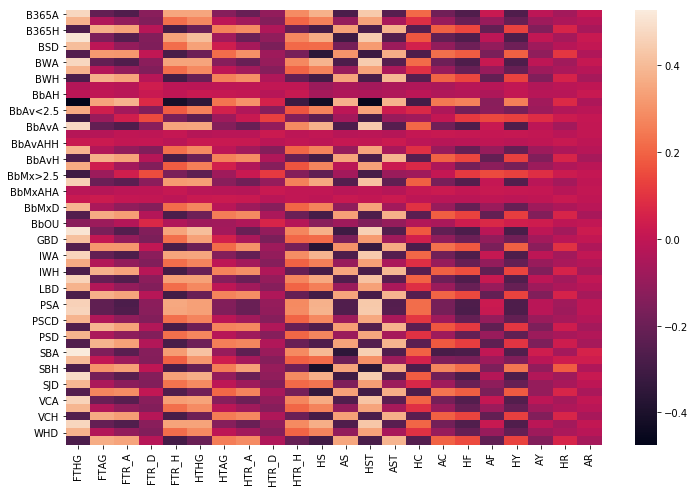

In [5]:
features_to_predict = ['FTHG', 'FTAG', 'FTR_A', 'FTR_D', 'FTR_H', 
                       'HTHG', 'HTAG', 'HTR_A', 'HTR_D', 'HTR_H', 
                       'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 
                       'AF', 'HY', 'AY', 'HR', 'AR']

df_corr = df_football.corr().filter(features_to_predict).drop(features_to_predict)

sns.heatmap(df_corr)

In [6]:
final_features_to_predict = [feat for feat in features_to_predict 
                            if len(df_corr[df_corr.abs()[feat] > 0.5]) > 0]
final_features_to_predict

['FTHG']

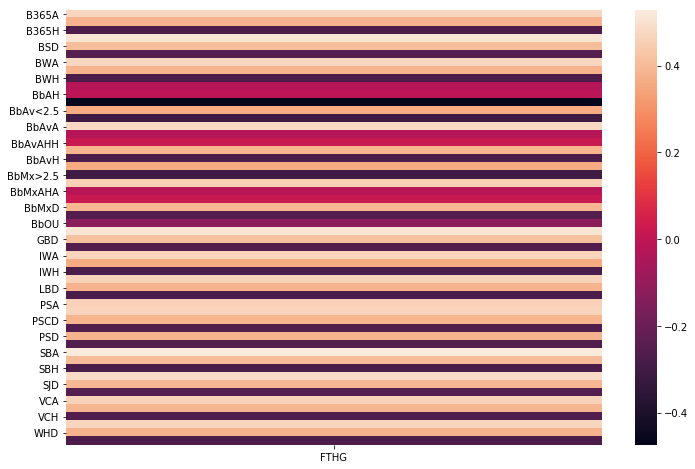

In [7]:
 sns.heatmap(df_corr[['FTHG']])

In [87]:
df = df_football[df_corr[['FTHG']].index]
df = pd.concat([df, df_football['FTHG']], axis=1)

df.head()

,B365A,B365D,B365H,BSA,BSD,BSH,BWA,BWD,BWH,Bb1X2,...,SJA,SJD,SJH,VCA,VCD,VCH,WHA,WHD,WHH,FTHG
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-27,3.00,3.40,2.30,2.75,3.30,2.40,2.85,3.40,2.35,43,...,3.0,3.30,2.40,3.0,3.5,2.40,3.1,3.30,2.30,0
2011-08-27,3.75,3.25,2.05,3.40,3.30,2.05,3.60,3.25,2.05,43,...,3.5,3.30,2.15,4.0,3.4,2.10,3.6,3.20,2.10,1
2011-08-27,8.00,4.33,1.40,7.00,4.00,1.44,7.00,4.20,1.45,43,...,7.5,4.33,1.44,8.5,4.5,1.44,8.0,4.00,1.44,4
2011-08-28,6.00,3.75,1.57,5.00,3.75,1.62,5.25,3.80,1.62,43,...,5.5,4.00,1.62,6.5,4.0,1.62,6.0,3.60,1.60,1
2011-08-28,6.50,3.80,1.53,5.50,3.75,1.57,6.25,3.80,1.55,43,...,6.0,4.00,1.57,6.5,4.0,1.57,6.0,3.75,1.57,0


Text(0.5,0,'percentage')

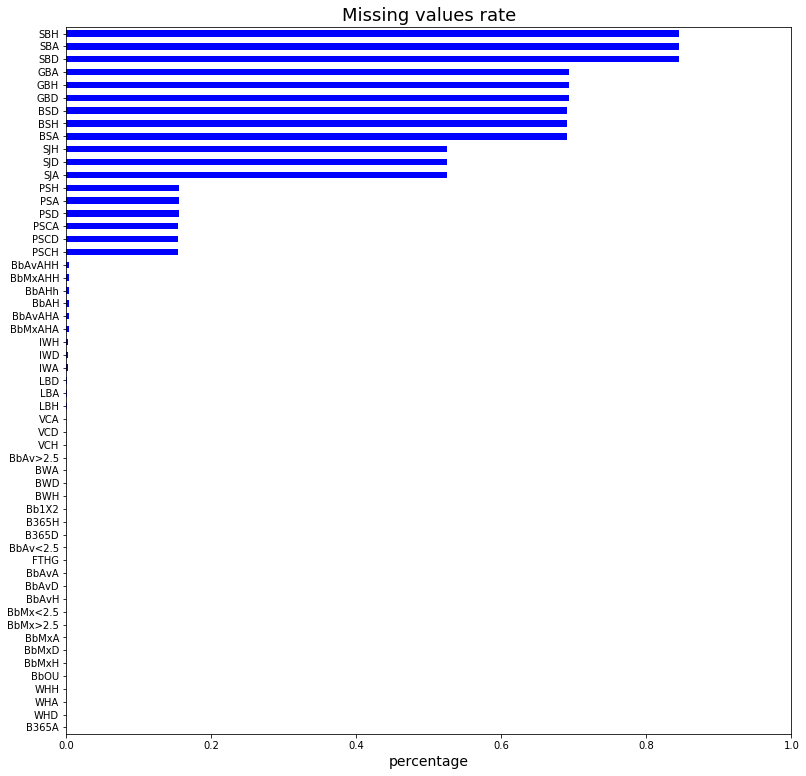

In [88]:
null_data = df.isnull().mean()

plt.figure(figsize = (13, 13))
null_data.sort_values().plot.barh(color = 'blue')
plt.xlim(xmax = 1)
plt.title("Missing values rate", fontsize = 18)
plt.xlabel("percentage", fontsize = 14)

In [89]:
features_wanted = null_data[null_data < 0.3].index
    
df = df[features_wanted]
df = df.fillna(round(df.mean(), 2))

df.head()

,B365A,B365D,B365H,BWA,BWD,BWH,Bb1X2,BbAH,BbAHh,BbAv<2.5,...,PSCH,PSD,PSH,VCA,VCD,VCH,WHA,WHD,WHH,FTHG
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-27,3.00,3.40,2.30,2.85,3.40,2.35,43,19.0,-0.25,1.76,...,3.03,4.75,3.05,3.0,3.5,2.40,3.1,3.30,2.30,0
2011-08-27,3.75,3.25,2.05,3.60,3.25,2.05,43,20.0,-0.50,1.70,...,3.03,4.75,3.05,4.0,3.4,2.10,3.6,3.20,2.10,1
2011-08-27,8.00,4.33,1.40,7.00,4.20,1.45,43,21.0,-1.25,2.00,...,3.03,4.75,3.05,8.5,4.5,1.44,8.0,4.00,1.44,4
2011-08-28,6.00,3.75,1.57,5.25,3.80,1.62,43,21.0,-1.00,1.95,...,3.03,4.75,3.05,6.5,4.0,1.62,6.0,3.60,1.60,1
2011-08-28,6.50,3.80,1.53,6.25,3.80,1.55,43,22.0,-1.00,1.91,...,3.03,4.75,3.05,6.5,4.0,1.57,6.0,3.75,1.57,0


In [90]:
df.shape

(2459, 43)

# Separación de datos de entrenamiento y test

In [91]:
df_X = df.copy()
df_y = df_X['FTHG']
del df_X['FTHG']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,
                                                    test_size = 0.25, random_state = 42)

In [92]:
print("X_train: " + str(X_train.shape))
print("X_test:  " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test:  " + str(y_test.shape))

X_train: (1844, 42)
X_test:  (615, 42)
y_train: (1844,)
y_test:  (615,)


# Regresión lineal básica

In [104]:
reg_LR = LinearRegression()
reg_LR.fit(X_train, y_train)
y_pred_LR = reg_LR.predict(X_test)

In [111]:
reg_LR.intercept_

2.5297715317827465

In [118]:
print('Intercept: ', reg_LR.intercept_)
print('Coefficients: \n', reg_LR.coef_)

Intercept:  2.52977153178
Coefficients: 
 [ 0.04048617 -0.05359916  0.12906844 -0.00735517  0.21238085 -0.00748795
  0.00474551 -0.00668541 -0.2789562   0.30429835 -0.41151868  0.31053392
 -0.17987612  0.46335653 -0.2983696  -0.32437301 -0.02825962  0.02426117
 -0.11522022  0.07766938 -0.34229179  0.17065827  0.05558237 -0.01577741
 -0.03352599 -0.19347873  0.0191437  -0.0070154   0.06658405  0.01590405
 -0.04687675 -0.00746413  0.14693507 -0.11785954 -0.07163404  0.10534678
  0.00533622 -0.12853665  0.02833046 -0.04622563 -0.01914095  0.05455982]


In [124]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_LR))

# Explained variance score
print('Variance score: %.2f' % r2_score(y_test, y_pred_LR))


def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# The Mean absolute percentage error
print('MAPE score: %.2f' % MAPE(y_test, y_pred_LR))

Mean squared error: 1.51
Variance score: 0.19
MAPE score: inf
